#OEE Forecasting with Deep Learning Models
This notebook implements and compares multiple deep learning models for Overall Equipment Effectiveness (OEE) forecasting using time series data.

##1. Data Loading and Initial Setup

In [ ]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (SimpleRNN, Dense, Dropout, Masking,
                                   Conv1D, Input, Concatenate, GlobalAveragePooling1D)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Load overall daily OEE data
df_overall = pd.read_csv('overall_daily_oee.csv', parse_dates=["Date"])
print("Overall OEE data shape:", df_overall.shape)
print("Data types:")
print(df_overall.dtypes)
df_overall.head()

In [ ]:
# Load per-line daily OEE reports
line_report_pattern = "daily_oee_report_*.csv"
line_report_files = glob.glob(line_report_pattern)

per_line_dataframes = {}

if not line_report_files:
    print(f"\nNo per-line report files found matching the pattern: '{line_report_pattern}'")
    print("Please ensure files like 'daily_oee_report_Line A.csv' exist in the working directory.")
else:
    print(f"\nFound {len(line_report_files)} per-line report files:")
    for filepath in line_report_files:
        # Extract production line name from filename
        filename = os.path.basename(filepath)
        prefix = "daily_oee_report_"
        suffix = ".csv"

        if filename.startswith(prefix) and filename.endswith(suffix):
            production_line_name = filename[len(prefix):-len(suffix)]
        else:
            print(f"Warning: Filename '{filename}' doesn't match expected pattern. Using fallback key.")
            production_line_name = os.path.splitext(filename)[0]

        # Read the CSV with date parsing
        df_line = pd.read_csv(filepath, parse_dates=["Date"])
        per_line_dataframes[production_line_name] = df_line

        print(f"\nSuccessfully read: {filepath} (Production Line: '{production_line_name}')")
        print(f"Shape: {df_line.shape}")
        display(df_line.head())
        print(f"Data types for '{production_line_name}':")
        print(df_line.dtypes)
        print("-" * 50)

##2. Helper Functions


In [ ]:
def create_sequences(data_1d, look_back, forecast_horizon=1):
    """
    Create sequences for time series forecasting.

    Args:
        data_1d: 1D array of time series data
        look_back: Number of previous time steps to use as input
        forecast_horizon: Number of steps to predict ahead

    Returns:
        X: Input sequences [samples, look_back, 1]
        y: Target values [samples] or [samples, forecast_horizon]
    """
    X, y = [], []
    if len(data_1d) <= look_back + forecast_horizon - 1:
        return np.array(X), np.array(y)

    for i in range(len(data_1d) - look_back - forecast_horizon + 1):
        input_seq = data_1d[i:(i + look_back)]
        output_val = data_1d[i + look_back : i + look_back + forecast_horizon]
        X.append(input_seq)
        y.append(output_val)

    X = np.array(X)
    if X.ndim == 2 and X.size > 0:
        X = X.reshape((X.shape[0], X.shape[1], 1))

    y = np.array(y)
    if forecast_horizon == 1 and y.ndim > 1 and y.size > 0:
        y = y.ravel()

    return X, y

def mean_absolute_percentage_error_safe(y_true, y_pred, epsilon=1e-8):
    """Calculate MAPE with safe division to avoid division by zero."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (np.maximum(np.abs(y_true), epsilon)))) * 100

##3. Data Preparation

In [ ]:
# Configuration
LOOK_BACK_VALUES = [7, 14, 19, 28, 30]  # Different look-back windows to test
FORECAST_HORIZON = 1  # Single-step prediction
TRAIN_SIZE_PERCENT = 0.7
VALIDATION_SIZE_PERCENT = 0.15
# TEST_SIZE_PERCENT will be the remainder (0.15)

# Master dictionary to store all prepared data
all_prepared_data = {}

# Prepare data sources
data_sources_to_process = {}

# Add Overall OEE data
if 'df_overall' in locals() and isinstance(df_overall, pd.DataFrame) and not df_overall.empty:
    data_sources_to_process['Overall'] = df_overall.copy()
else:
    print("Overall OEE data not available, skipping.")

# Add per-line OEE data
if 'per_line_dataframes' in locals() and isinstance(per_line_dataframes, dict):
    for line_name, df_line in per_line_dataframes.items():
        if isinstance(df_line, pd.DataFrame) and not df_line.empty:
            data_sources_to_process[line_name] = df_line.copy()
        else:
            print(f"Data for {line_name} not available or empty, skipping.")
else:
    print("Per-line OEE data not available, skipping.")

print(f"\n{'='*60}")
print(f"STARTING DATA PREPARATION FOR {len(data_sources_to_process)} SOURCES")
print(f"{'='*60}")

for source_name, source_df_original in data_sources_to_process.items():
    print(f"\n--- Preparing data for: {source_name} ---")
    current_prepared_data = {}
    source_df = source_df_original.copy()

    # Validate required columns
    if 'OEE' not in source_df.columns or 'Date' not in source_df.columns:
        print(f"  Error: Missing 'OEE' or 'Date' column for {source_name}. Skipping.")
        continue

    # Prepare time series data
    source_df['Date'] = pd.to_datetime(source_df['Date'])
    source_df = source_df.sort_values('Date').reset_index(drop=True)
    oee_data_current = source_df.set_index('Date')['OEE'].dropna()

    if oee_data_current.empty:
        print(f"  Error: OEE data for {source_name} is empty after cleaning. Skipping.")
        continue

    print(f"  Original data length: {len(oee_data_current)}")

    # Train/Validation/Test split
    n = len(oee_data_current)
    train_end_idx = int(n * TRAIN_SIZE_PERCENT)
    val_end_idx = train_end_idx + int(n * VALIDATION_SIZE_PERCENT)

    train_data_orig = oee_data_current.iloc[:train_end_idx]
    val_data_orig = oee_data_current.iloc[train_end_idx:val_end_idx]
    test_data_orig = oee_data_current.iloc[val_end_idx:]

    print(f"  Split sizes - Train: {len(train_data_orig)}, Val: {len(val_data_orig)}, Test: {len(test_data_orig)}")

    if not all(len(s) > 0 for s in [train_data_orig, val_data_orig, test_data_orig]):
        print(f"  Error: One of the data splits is empty. Skipping {source_name}.")
        continue

    # Scaling (fit only on training data)
    scaler = RobustScaler()
    train_data_reshaped = train_data_orig.values.reshape(-1, 1)
    scaler.fit(train_data_reshaped)
    current_prepared_data['scaler'] = scaler

    # Transform all splits
    train_scaled_1d = scaler.transform(train_data_reshaped).flatten()
    val_scaled_1d = scaler.transform(val_data_orig.values.reshape(-1, 1)).flatten() if not val_data_orig.empty else np.array([])
    test_scaled_1d = scaler.transform(test_data_orig.values.reshape(-1, 1)).flatten() if not test_data_orig.empty else np.array([])

    current_prepared_data['scaled_splits_1d'] = {
        'train': train_scaled_1d,
        'val': val_scaled_1d,
        'test': test_scaled_1d
    }

    print(f"  Scaled data shapes - Train: {len(train_scaled_1d)}, Val: {len(val_scaled_1d)}, Test: {len(test_scaled_1d)}")

    # Create sequences for different look-back windows
    for look_back in LOOK_BACK_VALUES:
        print(f"    Creating sequences for look_back = {look_back}...")

        # Train sequences
        X_train, y_train = create_sequences(train_scaled_1d, look_back, FORECAST_HORIZON)

        # Validation sequences (use tail of train + val data)
        val_input_data = np.array([])
        if len(train_scaled_1d) >= look_back and len(val_scaled_1d) > 0:
            val_input_data = np.concatenate([train_scaled_1d[-look_back:], val_scaled_1d])
        elif len(val_scaled_1d) > 0:
            val_input_data = val_scaled_1d
        X_val, y_val = create_sequences(val_input_data, look_back, FORECAST_HORIZON)

        # Test sequences (use tail of train+val + test data)
        combined_train_val = np.concatenate([train_scaled_1d, val_scaled_1d])
        test_input_data = np.array([])
        if len(combined_train_val) >= look_back and len(test_scaled_1d) > 0:
            test_input_data = np.concatenate([combined_train_val[-look_back:], test_scaled_1d])
        elif len(test_scaled_1d) > 0:
            test_input_data = test_scaled_1d
        X_test, y_test = create_sequences(test_input_data, look_back, FORECAST_HORIZON)

        current_prepared_data[look_back] = {
            'X_train': X_train, 'y_train': y_train,
            'X_val': X_val, 'y_val': y_val,
            'X_test': X_test, 'y_test': y_test
        }

        print(f"      Sequences created - X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

    all_prepared_data[source_name] = current_prepared_data
    print(f"--- Data preparation for {source_name} complete ---")

print(f"\n{'='*60}")
print("ALL DATA PREPARATION COMPLETE")
print(f"{'='*60}")

##4. Model Definitions

###4.1 Stacked SimpleRNN with Masking (for Padded Sequences)

In [ ]:
def build_stacked_simplernn_with_masking(input_shape_padded, units_list=[64, 32], dropout_rate=0.25):
    """
    Builds a stacked SimpleRNN model WITH a Masking layer for padded sequences.
    """
    model = Sequential(name=f"StackedSimpleRNN_Masking_Units{'_'.join(map(str, units_list))}")

    # Masking layer to handle padded sequences (ignores timesteps where all features are 0)
    model.add(Masking(mask_value=0., input_shape=input_shape_padded))

    # Stacked SimpleRNN layers
    for i, units in enumerate(units_list):
        is_last_rnn = (i == len(units_list) - 1)
        model.add(SimpleRNN(
            units,
            activation='tanh',
            return_sequences=not is_last_rnn
        ))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(FORECAST_HORIZON, activation='linear'))
    return model

def build_stacked_simplernn_no_masking(input_shape_padded, units_list=[64, 32], dropout_rate=0.2):
    """
    Builds a stacked SimpleRNN model WITHOUT a Masking layer.
    """
    model = Sequential(name=f"StackedSimpleRNN_NoMask_Units{'_'.join(map(str, units_list))}")

    # First SimpleRNN layer
    model.add(SimpleRNN(
        units_list[0],
        activation='tanh',
        input_shape=input_shape_padded,
        return_sequences=True if len(units_list) > 1 else False
    ))
    model.add(Dropout(dropout_rate))

    # Additional RNN layers
    for i in range(1, len(units_list)):
        is_last_rnn = (i == len(units_list) - 1)
        model.add(SimpleRNN(
            units_list[i],
            activation='tanh',
            return_sequences=not is_last_rnn
        ))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(FORECAST_HORIZON, activation='linear'))
    return model

###4.2 Multi-Kernel CNN Model

In [ ]:
def build_multi_kernel_cnn(input_shape):
    """
    Builds a CNN with multiple parallel convolutional towers using different kernel sizes.
    Inspired by ROCKET's diverse kernel approach.
    """
    inputs = Input(shape=input_shape, name="MultiKernel_Input")
    towers_outputs = []

    # Tower 1: Small kernel (size 3)
    if input_shape[0] >= 3:
        tower_1 = Conv1D(filters=16, kernel_size=3, activation='relu',
                        padding='causal', name="MK_Tower1_Conv")(inputs)
        tower_1 = GlobalAveragePooling1D(name="MK_Tower1_GAP")(tower_1)
        towers_outputs.append(tower_1)

    # Tower 2: Medium kernel (size 5)
    if input_shape[0] >= 5:
        tower_2 = Conv1D(filters=16, kernel_size=5, activation='relu',
                        padding='causal', name="MK_Tower2_Conv")(inputs)
        tower_2 = GlobalAveragePooling1D(name="MK_Tower2_GAP")(tower_2)
        towers_outputs.append(tower_2)

    # Tower 3: Large kernel (size 7)
    if input_shape[0] >= 7:
        tower_3 = Conv1D(filters=16, kernel_size=7, activation='relu',
                        padding='causal', name="MK_Tower3_Conv")(inputs)
        tower_3 = GlobalAveragePooling1D(name="MK_Tower3_GAP")(tower_3)
        towers_outputs.append(tower_3)

    # Fallback for very short sequences
    if not towers_outputs:
        kernel_s = min(3, input_shape[0])
        if kernel_s < 1:
            kernel_s = 1
        fallback = Conv1D(filters=16, kernel_size=kernel_s, activation='relu',
                         padding='causal')(inputs)
        merged = GlobalAveragePooling1D()(fallback)
    elif len(towers_outputs) == 1:
        merged = towers_outputs[0]
    else:
        merged = Concatenate(name="MK_Concatenate_Towers")(towers_outputs)

    # Dense layers
    merged_dropout = Dropout(0.3, name="MK_Merged_Drop")(merged)
    dense_output = Dense(32, activation='relu', name="MK_Dense1")(merged_dropout)
    final_dropout = Dropout(0.3, name="MK_Final_Drop")(dense_output)
    outputs = Dense(1, name="MK_FinalOutput")(final_dropout)

    model = Model(inputs=inputs, outputs=outputs, name="MultiKernelCNN")
    return model

###4.3 WaveNet-style Dilated CNN Model

In [ ]:
def build_wavenet_style_cnn(input_shape,
                           n_conv_layers=6,
                           base_filters=32,
                           kernel_size=2,
                           dense_units=16,
                           dropout_rate=0.2):
    """
    Builds a WaveNet-style model with dilated convolutions.

    Architecture:
    - 6 layers of 1D dilated convolutional layers
    - Dilation rates: 1, 2, 4, 8, 16, 32 (powers of 2)
    - Final 1D convolution with kernel size 1
    """
    model = Sequential(name="WaveNetStyle_DilatedCNN")

    # First layer
    model.add(Conv1D(filters=base_filters,
                     kernel_size=kernel_size,
                     dilation_rate=1,
                     activation='relu',
                     padding='causal',
                     input_shape=input_shape,
                     name="WN_Conv1_Dil1"))

    # Subsequent dilated layers
    for i in range(1, n_conv_layers):
        dilation_rate = 2 ** i  # 2, 4, 8, 16, 32
        model.add(Conv1D(filters=base_filters,
                         kernel_size=kernel_size,
                         dilation_rate=dilation_rate,
                         activation='relu',
                         padding='causal',
                         name=f"WN_Conv{i+1}_Dil{dilation_rate}"))

    # Final 1D convolution with kernel size 1
    model.add(Conv1D(filters=1, kernel_size=1, activation='linear',
                     padding='causal', name="WN_Final_Conv1x1"))

    # Global pooling and dense layers
    model.add(GlobalAveragePooling1D(name="WN_GlobalAvgPool"))
    model.add(Dense(dense_units, activation='relu', name="WN_Dense"))
    model.add(Dropout(dropout_rate, name="WN_Dropout"))
    model.add(Dense(FORECAST_HORIZON, activation='linear', name="WN_Output"))

    return model

#5. Walk-Forward Validation Functions

##5.1 For Padded Models (RNN with Masking/No Masking)

In [ ]:
def evaluate_walk_forward_for_padded_model(
    model_builder_func,
    model_name_prefix,
    train_scaled_1d, val_scaled_1d, test_scaled_1d,
    original_look_back,
    target_padded_length,
    scaler_obj,
    epochs_wf, batch_size_wf, verbose_fit_wf,
    line_name_context,
    n_features=1):
    """
    Walk-forward validation for models that use padded sequences.
    """
    full_model_name = f"{model_name_prefix}_LB{original_look_back}_PadTo{target_padded_length}"
    print(f"\n--- Evaluating {full_model_name} with Walk-Forward for {line_name_context} ---")

    initial_history_scaled = np.concatenate([train_scaled_1d, val_scaled_1d])
    predictions_scaled_list = []
    actuals_scaled_list = []

    early_stopping_wf = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=0)
    reduce_lr_wf = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-6, verbose=0)

    for i in range(len(test_scaled_1d)):
        current_train_window_1d_scaled = np.concatenate([initial_history_scaled, test_scaled_1d[:i]])

        # Create original sequences
        X_current_train_orig_seq, y_current_train = create_sequences(
            current_train_window_1d_scaled, original_look_back, FORECAST_HORIZON
        )

        if X_current_train_orig_seq.shape[0] == 0:
            actuals_scaled_list.append(test_scaled_1d[i])
            predictions_scaled_list.append(np.nan)
            continue

        # Pad sequences
        X_train_to_pad = np.squeeze(X_current_train_orig_seq, axis=-1) if X_current_train_orig_seq.ndim == 3 else X_current_train_orig_seq
        X_current_train_padded = pad_sequences(X_train_to_pad, maxlen=target_padded_length,
                                             padding='pre', truncating='pre', dtype='float32', value=0.0)
        X_current_train_padded = X_current_train_padded.reshape((X_current_train_padded.shape[0], target_padded_length, n_features))

        # Build and train model
        tf.keras.backend.clear_session()
        model = model_builder_func((target_padded_length, n_features))
        model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(), metrics=['mae'])

        model.fit(X_current_train_padded, y_current_train, epochs=epochs_wf, batch_size=batch_size_wf,
                  callbacks=[early_stopping_wf, reduce_lr_wf], verbose=verbose_fit_wf)

        # Prepare prediction sequence
        last_sequence_data_orig = current_train_window_1d_scaled[-original_look_back:]
        last_sequence_to_pad = last_sequence_data_orig.reshape(1, -1)
        last_sequence_for_pred_padded = pad_sequences(last_sequence_to_pad, maxlen=target_padded_length,
                                                    padding='pre', truncating='pre', dtype='float32', value=0.0)
        last_sequence_for_pred_padded = last_sequence_for_pred_padded.reshape(1, target_padded_length, n_features)

        # Make prediction
        prediction_scaled = model.predict(last_sequence_for_pred_padded, verbose=0)[0, 0]
        predictions_scaled_list.append(prediction_scaled)
        actuals_scaled_list.append(test_scaled_1d[i])

    # Calculate metrics
    predictions_scaled_arr = np.array(predictions_scaled_list).reshape(-1, 1)
    actuals_scaled_arr = np.array(actuals_scaled_list).reshape(-1, 1)
    valid_pred_indices = ~np.isnan(predictions_scaled_arr.flatten())

    if not np.any(valid_pred_indices):
        print("  No valid predictions made during walk-forward.")
        return None

    # Convert back to original scale
    predictions_original_scale = np.full_like(predictions_scaled_arr, np.nan, dtype=float)
    predictions_original_scale[valid_pred_indices] = scaler_obj.inverse_transform(predictions_scaled_arr[valid_pred_indices])
    actuals_original_scale = scaler_obj.inverse_transform(actuals_scaled_arr)

    final_predictions = predictions_original_scale[valid_pred_indices].flatten()
    final_actuals = actuals_original_scale[valid_pred_indices].flatten()

    if len(final_actuals) == 0 or len(final_predictions) == 0:
        print("  Not enough valid data to calculate metrics.")
        return None

    # Calculate metrics
    mae = mean_absolute_error(final_actuals, final_predictions)
    rmse = np.sqrt(mean_squared_error(final_actuals, final_predictions))
    mape = mean_absolute_percentage_error_safe(final_actuals, final_predictions)

    print(f"\n{full_model_name} - Walk-Forward Metrics (Original Scale) for {line_name_context}:")
    print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

    # Visualization
    plt.figure(figsize=(14, 6))
    time_steps_plot = np.arange(len(final_actuals))
    plt.plot(time_steps_plot, final_actuals, label='Actual OEE', marker='.', linestyle='-')
    plt.plot(time_steps_plot, final_predictions, label='Predicted OEE (Walk-Forward)', marker='x', linestyle='--')
    plt.title(f'Walk-Forward: {full_model_name} - {line_name_context}')
    plt.xlabel('Time Step in Test Set')
    plt.ylabel('OEE (Original Scale)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {'mae': mae, 'rmse': rmse, 'mape': mape, 'predictions': final_predictions, 'actuals': final_actuals}

##5.2 For Non-Padded Models (CNN Models)

In [ ]:
def evaluate_walk_forward(
    model_builder_func,
    model_name,
    train_scaled_1d, val_scaled_1d, test_scaled_1d,
    look_back,
    scaler_obj,
    epochs_wf, batch_size_wf, verbose_fit_wf,
    line_name_context):
    """
    Walk-forward validation for models that don't use padding (CNN models).
    """
    print(f"\n--- Evaluating {model_name} with Walk-Forward (LB: {look_back}) for {line_name_context} ---")

    initial_history_scaled = np.concatenate([train_scaled_1d, val_scaled_1d])
    predictions_scaled_list = []
    actuals_scaled_list = []

    early_stopping_wf = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=0)
    reduce_lr_wf = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-6, verbose=0)

    for i in range(len(test_scaled_1d)):
        current_train_window_1d_scaled = np.concatenate([initial_history_scaled, test_scaled_1d[:i]])

        # Create sequences (no padding)
        X_current_train, y_current_train = create_sequences(
            current_train_window_1d_scaled, look_back, FORECAST_HORIZON
        )

        if X_current_train.shape[0] == 0:
            actuals_scaled_list.append(test_scaled_1d[i])
            predictions_scaled_list.append(np.nan)
            continue

        # Build and train model
        tf.keras.backend.clear_session()
        model = model_builder_func((look_back, 1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(), metrics=['mae'])

        model.fit(X_current_train, y_current_train, epochs=epochs_wf, batch_size=batch_size_wf,
                  callbacks=[early_stopping_wf, reduce_lr_wf], verbose=verbose_fit_wf)

        # Prepare prediction sequence
        last_sequence = current_train_window_1d_scaled[-look_back:].reshape(1, look_back, 1)

        # Make prediction
        prediction_scaled = model.predict(last_sequence, verbose=0)[0, 0]
        predictions_scaled_list.append(prediction_scaled)
        actuals_scaled_list.append(test_scaled_1d[i])

    # Calculate metrics (same as padded version)
    predictions_scaled_arr = np.array(predictions_scaled_list).reshape(-1, 1)
    actuals_scaled_arr = np.array(actuals_scaled_list).reshape(-1, 1)
    valid_pred_indices = ~np.isnan(predictions_scaled_arr.flatten())

    if not np.any(valid_pred_indices):
        print("  No valid predictions made during walk-forward.")
        return None

    predictions_original_scale = np.full_like(predictions_scaled_arr, np.nan, dtype=float)
    predictions_original_scale[valid_pred_indices] = scaler_obj.inverse_transform(predictions_scaled_arr[valid_pred_indices])
    actuals_original_scale = scaler_obj.inverse_transform(actuals_scaled_arr)

    final_predictions = predictions_original_scale[valid_pred_indices].flatten()
    final_actuals = actuals_original_scale[valid_pred_indices].flatten()

    if len(final_actuals) == 0 or len(final_predictions) == 0:
        print("  Not enough valid data to calculate metrics.")
        return None

    mae = mean_absolute_error(final_actuals, final_predictions)
    rmse = np.sqrt(mean_squared_error(final_actuals, final_predictions))
    mape = mean_absolute_percentage_error_safe(final_actuals, final_predictions)

    print(f"\n{model_name} - Walk-Forward Metrics (Original Scale) for {line_name_context}:")
    print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

    # Visualization
    plt.figure(figsize=(14, 6))
    time_steps_plot = np.arange(len(final_actuals))
    plt.plot(time_steps_plot, final_actuals, label='Actual OEE', marker='.', linestyle='-')
    plt.plot(time_steps_plot, final_predictions, label=f'Predicted OEE ({model_name})', marker='x', linestyle='--')
    plt.title(f'Walk-Forward: {model_name} - {line_name_context}')
    plt.xlabel('Time Step in Test Set')
    plt.ylabel('OEE (Original Scale)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {'mae': mae, 'rmse': rmse, 'mape': mape, 'predictions': final_predictions, 'actuals': final_actuals}

#6. Model Training and Evaluation

##6.1 Model 1: Stacked SimpleRNN with Masking (LB 14, Padded to 20)


MODEL 1: STACKED SIMPLERNN WITH MASKING
Look-back: 14, Padded to: 20

--- Evaluating StackedSimpleRNN_Masking_LB14_PadTo20 with Walk-Forward for Overall ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



StackedSimpleRNN_Masking_LB14_PadTo20 - Walk-Forward Metrics (Original Scale) for Overall:
  MAE: 0.0844, RMSE: 0.1837, MAPE: 679.38%


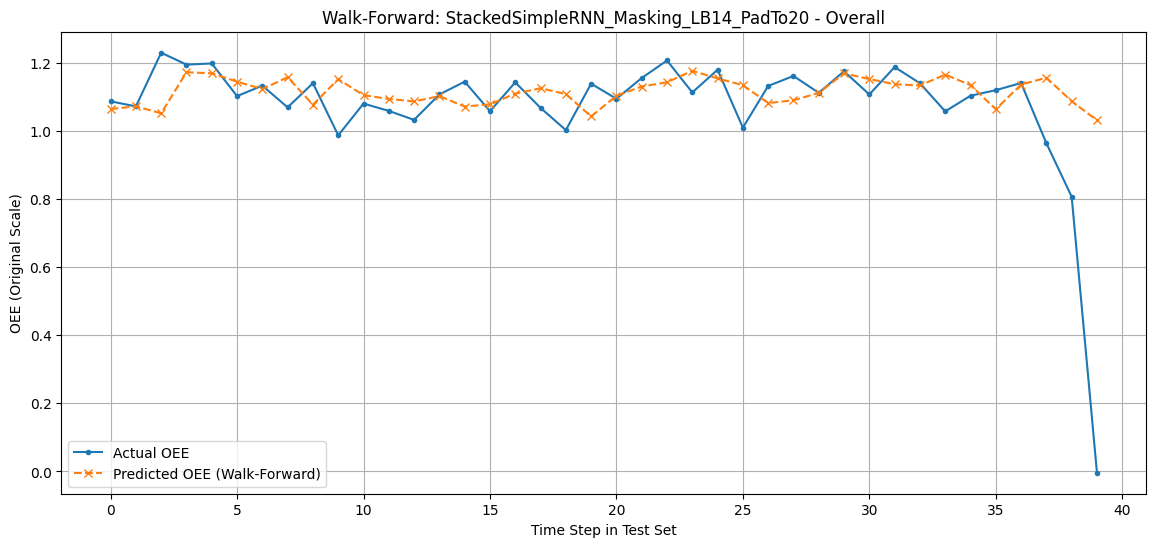


--- Evaluating StackedSimpleRNN_Masking_LB14_PadTo20 with Walk-Forward for LINE-01 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



StackedSimpleRNN_Masking_LB14_PadTo20 - Walk-Forward Metrics (Original Scale) for LINE-01:
  MAE: 0.1655, RMSE: 0.2228, MAPE: 209441738.56%


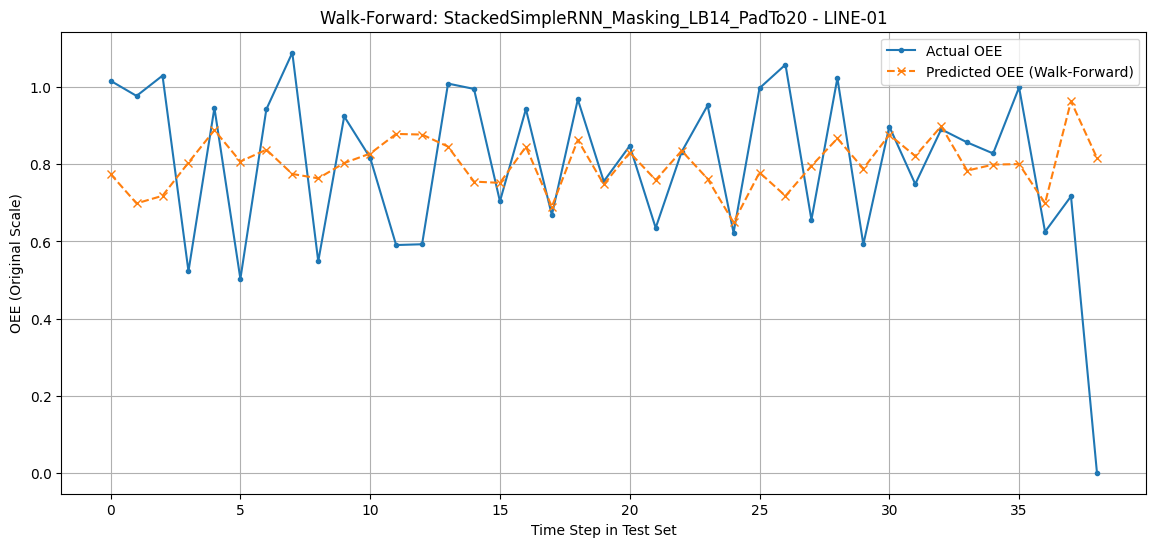


--- Evaluating StackedSimpleRNN_Masking_LB14_PadTo20 with Walk-Forward for LINE-03 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Configuration for Model 1
SELECTED_LOOK_BACK_1 = 14
TARGET_PADDED_LENGTH_1 = 20
N_FEATURES_1 = 1

# Training parameters
EPOCHS_WF_1 = 30
BATCH_SIZE_WF_1 = 32
VERBOSE_FIT_WF_1 = 0

# Model parameters
rnn_units_list_1 = [64, 32]
rnn_dropout_rate_1 = 0.25

# Results storage
all_walk_forward_results_model1 = {}

print(f"\n{'='*60}")
print(f"MODEL 1: STACKED SIMPLERNN WITH MASKING")
print(f"Look-back: {SELECTED_LOOK_BACK_1}, Padded to: {TARGET_PADDED_LENGTH_1}")
print(f"{'='*60}")

for source_name, prepared_data in all_prepared_data.items():
    if not isinstance(prepared_data, dict) or 'scaler' not in prepared_data or 'scaled_splits_1d' not in prepared_data:
        print(f"Skipping {source_name}: Incomplete prepared data")
        continue

    scaler_current = prepared_data['scaler']
    scaled_splits = prepared_data['scaled_splits_1d']
    train_1d = scaled_splits.get('train')
    val_1d = scaled_splits.get('val')
    test_1d = scaled_splits.get('test')

    if train_1d is None or val_1d is None or test_1d is None or \
       train_1d.size == 0 or val_1d.size == 0 or test_1d.size == 0:
        print(f"Skipping {source_name}: Missing or empty data splits")
        continue

    # Model builder
    current_model_builder_1 = lambda input_shape_p: build_stacked_simplernn_with_masking(
        input_shape_padded=input_shape_p,
        units_list=rnn_units_list_1,
        dropout_rate=rnn_dropout_rate_1
    )

    # Evaluate
    wf_metrics_1 = evaluate_walk_forward_for_padded_model(
        model_builder_func=current_model_builder_1,
        model_name_prefix="StackedSimpleRNN_Masking",
        train_scaled_1d=train_1d,
        val_scaled_1d=val_1d,
        test_scaled_1d=test_1d,
        original_look_back=SELECTED_LOOK_BACK_1,
        target_padded_length=TARGET_PADDED_LENGTH_1,
        scaler_obj=scaler_current,
        epochs_wf=EPOCHS_WF_1,
        batch_size_wf=BATCH_SIZE_WF_1,
        verbose_fit_wf=VERBOSE_FIT_WF_1,
        line_name_context=source_name,
        n_features=N_FEATURES_1
    )

    if source_name not in all_walk_forward_results_model1:
        all_walk_forward_results_model1[source_name] = {}
    model_id_1 = f"StackedSimpleRNN_Masking_LB{SELECTED_LOOK_BACK_1}_PadTo{TARGET_PADDED_LENGTH_1}"
    all_walk_forward_results_model1[source_name][model_id_1] = wf_metrics_1

##6.2 Model 2: Stacked SimpleRNN without Masking (LB 7, Padded to 35)

In [ ]:
# Configuration for Model 2
SELECTED_LOOK_BACK_2 = 7
TARGET_PADDED_LENGTH_2 = 35
N_FEATURES_2 = 1

# Training parameters
EPOCHS_WF_2 = 40
BATCH_SIZE_WF_2 = 16
VERBOSE_FIT_WF_2 = 0

# Model parameters
rnn_units_list_2 = [64, 32]
rnn_dropout_rate_2 = 0.2

# Results storage
all_walk_forward_results_model2 = {}

print(f"\n{'='*60}")
print(f"MODEL 2: STACKED SIMPLERNN WITHOUT MASKING")
print(f"Look-back: {SELECTED_LOOK_BACK_2}, Padded to: {TARGET_PADDED_LENGTH_2}")
print(f"{'='*60}")

for source_name, prepared_data in all_prepared_data.items():
    if not isinstance(prepared_data, dict) or 'scaler' not in prepared_data or 'scaled_splits_1d' not in prepared_data:
        print(f"Skipping {source_name}: Incomplete prepared data")
        continue

    scaler_current = prepared_data['scaler']
    scaled_splits = prepared_data['scaled_splits_1d']
    train_1d = scaled_splits.get('train')
    val_1d = scaled_splits.get('val')
    test_1d = scaled_splits.get('test')

    if train_1d is None or val_1d is None or test_1d is None or \
       train_1d.size == 0 or val_1d.size == 0 or test_1d.size == 0:
        print(f"Skipping {source_name}: Missing or empty data splits")
        continue

    # Model builder
    current_model_builder_2 = lambda input_shape_p: build_stacked_simplernn_no_masking(
        input_shape_padded=input_shape_p,
        units_list=rnn_units_list_2,
        dropout_rate=rnn_dropout_rate_2
    )

    # Evaluate
    wf_metrics_2 = evaluate_walk_forward_for_padded_model(
        model_builder_func=current_model_builder_2,
        model_name_prefix="StackedSimpleRNN_NoMasking",
        train_scaled_1d=train_1d,
        val_scaled_1d=val_1d,
        test_scaled_1d=test_1d,
        original_look_back=SELECTED_LOOK_BACK_2,
        target_padded_length=TARGET_PADDED_LENGTH_2,
        scaler_obj=scaler_current,
        epochs_wf=EPOCHS_WF_2,
        batch_size_wf=BATCH_SIZE_WF_2,
        verbose_fit_wf=VERBOSE_FIT_WF_2,
        line_name_context=source_name,
        n_features=N_FEATURES_2
    )

    if source_name not in all_walk_forward_results_model2:
        all_walk_forward_results_model2[source_name] = {}
    model_id_2 = f"StackedSimpleRNN_NoMask_LB{SELECTED_LOOK_BACK_2}_PadTo{TARGET_PADDED_LENGTH_2}"
    all_walk_forward_results_model2[source_name][model_id_2] = wf_metrics_2

##6.3 Model 3: Multi-Kernel CNN (Walk-Forward, no padding)

In [ ]:
# Configuration for Model 3 (from Optuna optimization results)
SELECTED_LOOK_BACK_3 = 30  # From best hyperparameters

# Training parameters
EPOCHS_WF_3 = 50
BATCH_SIZE_WF_3 = 16
VERBOSE_FIT_WF_3 = 0

# Results storage
all_walk_forward_results_model3 = {}

print(f"\n{'='*60}")
print(f"MODEL 3: MULTI-KERNEL CNN")
print(f"Look-back: {SELECTED_LOOK_BACK_3} (no padding)")
print(f"{'='*60}")

for source_name, prepared_data in all_prepared_data.items():
    if not isinstance(prepared_data, dict) or 'scaler' not in prepared_data or SELECTED_LOOK_BACK_3 not in prepared_data:
        print(f"Skipping {source_name}: Missing data for look_back {SELECTED_LOOK_BACK_3}")
        continue

    scaler_current = prepared_data['scaler']
    scaled_splits = prepared_data['scaled_splits_1d']
    train_1d = scaled_splits.get('train')
    val_1d = scaled_splits.get('val')
    test_1d = scaled_splits.get('test')

    if train_1d is None or val_1d is None or test_1d is None or \
       train_1d.size == 0 or val_1d.size == 0 or test_1d.size == 0:
        print(f"Skipping {source_name}: Missing or empty data splits")
        continue

    # Evaluate
    mk_cnn_metrics = evaluate_walk_forward(
        model_builder_func=build_multi_kernel_cnn,
        model_name="MultiKernel-CNN",
        train_scaled_1d=train_1d,
        val_scaled_1d=val_1d,
        test_scaled_1d=test_1d,
        look_back=SELECTED_LOOK_BACK_3,
        scaler_obj=scaler_current,
        epochs_wf=EPOCHS_WF_3,
        batch_size_wf=BATCH_SIZE_WF_3,
        verbose_fit_wf=VERBOSE_FIT_WF_3,
        line_name_context=source_name
    )

    if source_name not in all_walk_forward_results_model3:
        all_walk_forward_results_model3[source_name] = {}
    model_id_3 = f"MultiKernel_CNN_LB{SELECTED_LOOK_BACK_3}"
    all_walk_forward_results_model3[source_name][model_id_3] = mk_cnn_metrics

##6.4 Model 4: WaveNet-style Dilated CNN

In [ ]:
# Configuration for Model 4
SELECTED_LOOK_BACK_4 = 14  # Window size from description
BATCH_SIZE_4 = 32         # Batch size from description
PREDICTED_STEPS_4 = 3     # Note: This model was designed for 3-step prediction

# Optimal hyperparameters from Optuna
LEARNING_RATE_4 = 0.0006831456312347647
N_CONV_LAYERS_4 = 2
BASE_FILTERS_4 = 32
KERNEL_SIZE_4 = 2
DENSE_UNITS_4 = 16
DROPOUT_RATE_4 = 0.17852580967037868

# Training parameters
EPOCHS_WF_4 = 50
VERBOSE_FIT_WF_4 = 0

# Results storage
all_walk_forward_results_model4_wf = {}
all_standard_results_model4 = {}

print(f"\n{'='*60}")
print(f"MODEL 4: WAVENET-STYLE DILATED CNN")
print(f"Look-back: {SELECTED_LOOK_BACK_4} (no padding)")
print(f"Testing both Walk-Forward and Standard Training")
print(f"{'='*60}")

for source_name, prepared_data in all_prepared_data.items():
    if not isinstance(prepared_data, dict) or 'scaler' not in prepared_data or SELECTED_LOOK_BACK_4 not in prepared_data:
        print(f"Skipping {source_name}: Missing data for look_back {SELECTED_LOOK_BACK_4}")
        continue

    scaler_current = prepared_data['scaler']
    scaled_splits = prepared_data['scaled_splits_1d']
    sequences_data = prepared_data[SELECTED_LOOK_BACK_4]

    train_1d = scaled_splits.get('train')
    val_1d = scaled_splits.get('val')
    test_1d = scaled_splits.get('test')

    X_train = sequences_data.get('X_train')
    y_train = sequences_data.get('y_train')
    X_test = sequences_data.get('X_test')
    y_test = sequences_data.get('y_test')

    if train_1d is None or val_1d is None or test_1d is None or \
       train_1d.size == 0 or val_1d.size == 0 or test_1d.size == 0:
        print(f"Skipping {source_name}: Missing or empty data splits")
        continue

    # Model builder with optimized hyperparameters
    wavenet_model_builder = lambda input_shape: build_wavenet_style_cnn(
        input_shape=input_shape,
        n_conv_layers=N_CONV_LAYERS_4,
        base_filters=BASE_FILTERS_4,
        kernel_size=KERNEL_SIZE_4,
        dense_units=DENSE_UNITS_4,
        dropout_rate=DROPOUT_RATE_4
    )

    # 1. Walk-Forward Evaluation
    print(f"\n  Testing Walk-Forward for {source_name}...")
    wn_wf_metrics = evaluate_walk_forward(
        model_builder_func=wavenet_model_builder,
        model_name="WaveNet-Style-CNN (Walk-Forward)",
        train_scaled_1d=train_1d,
        val_scaled_1d=val_1d,
        test_scaled_1d=test_1d,
        look_back=SELECTED_LOOK_BACK_4,
        scaler_obj=scaler_current,
        epochs_wf=EPOCHS_WF_4,
        batch_size_wf=BATCH_SIZE_4,
        verbose_fit_wf=VERBOSE_FIT_WF_4,
        line_name_context=source_name
    )

    if source_name not in all_walk_forward_results_model4_wf:
        all_walk_forward_results_model4_wf[source_name] = {}
    model_id_4_wf = f"WaveNet_CNN_WF_LB{SELECTED_LOOK_BACK_4}"
    all_walk_forward_results_model4_wf[source_name][model_id_4_wf] = wn_wf_metrics

    # 2. Standard Training (single model on full training data)
    print(f"\n  Testing Standard Training for {source_name}...")
    if X_train.size > 0 and y_train.size > 0 and X_test.size > 0 and y_test.size > 0:
        # Build and train model
        tf.keras.backend.clear_session()
        wavenet_model = wavenet_model_builder((SELECTED_LOOK_BACK_4, 1))
        wavenet_model.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE_4),
            loss=Huber(),
            metrics=['mae']
        )

        # Callbacks
        early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=7, min_lr=1e-6, verbose=0)

        # Train
        history = wavenet_model.fit(
            X_train, y_train,
            epochs=EPOCHS_WF_4,
            batch_size=BATCH_SIZE_4,
            callbacks=[early_stopping, reduce_lr],
            verbose=VERBOSE_FIT_WF_4
        )

        # Predict on test set
        y_pred_scaled = wavenet_model.predict(X_test, verbose=0).flatten()

        # Convert back to original scale
        y_test_original = scaler_current.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_original = scaler_current.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        # Calculate metrics
        mae_std = mean_absolute_error(y_test_original, y_pred_original)
        rmse_std = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
        mape_std = mean_absolute_percentage_error_safe(y_test_original, y_pred_original)

        print(f"\nWaveNet-Style-CNN (Standard) - Metrics for {source_name}:")
        print(f"  MAE: {mae_std:.4f}, RMSE: {rmse_std:.4f}, MAPE: {mape_std:.2f}%")

        # Visualization
        plt.figure(figsize=(14, 6))
        time_steps_plot = np.arange(len(y_test_original))
        plt.plot(time_steps_plot, y_test_original, label='Actual OEE', marker='.', linestyle='-')
        plt.plot(time_steps_plot, y_pred_original, label='Predicted OEE (Standard)', marker='x', linestyle='--')
        plt.title(f'Standard Training: WaveNet-Style-CNN - {source_name}')
        plt.xlabel('Time Step in Test Set')
        plt.ylabel('OEE (Original Scale)')
        plt.legend()
        plt.grid(True)
        plt.show()

        if source_name not in all_standard_results_model4:
            all_standard_results_model4[source_name] = {}
        model_id_4_std = f"WaveNet_CNN_Standard_LB{SELECTED_LOOK_BACK_4}"
        all_standard_results_model4[source_name][model_id_4_std] = {
            'mae': mae_std, 'rmse': rmse_std, 'mape': mape_std,
            'predictions': y_pred_original, 'actuals': y_test_original
        }
    else:
        print(f"  Skipping standard training for {source_name}: Empty sequence data")

#7. Results Summary

In [ ]:
print(f"\n{'='*80}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*80}")

def print_results_summary(results_dict, model_description):
    """Helper function to print results in a formatted way."""
    print(f"\n{'-'*60}")
    print(f"{model_description}")
    print(f"{'-'*60}")

    for source_name, source_results in results_dict.items():
        print(f"\n📊 Results for {source_name}:")
        for model_key, metrics in source_results.items():
            if metrics and isinstance(metrics, dict):
                print(f"  🔹 {model_key}")
                print(f"     MAE: {metrics['mae']:.4f} | RMSE: {metrics['rmse']:.4f} | MAPE: {metrics['mape']:.2f}%")
            else:
                print(f"  🔹 {model_key}: No valid results")

# Print all results
print_results_summary(all_walk_forward_results_model1, "MODEL 1: Stacked SimpleRNN with Masking (LB 14, Padded to 20)")
print_results_summary(all_walk_forward_results_model2, "MODEL 2: Stacked SimpleRNN without Masking (LB 7, Padded to 35)")
print_results_summary(all_walk_forward_results_model3, "MODEL 3: Multi-Kernel CNN (LB 30, Walk-Forward)")
print_results_summary(all_walk_forward_results_model4_wf, "MODEL 4: WaveNet-Style CNN (LB 14, Walk-Forward)")
print_results_summary(all_standard_results_model4, "MODEL 4: WaveNet-Style CNN (LB 14, Standard Training)")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE")
print(f"{'='*80}")

#8. Model Comparison and Best Performance Analysis

In [ ]:
# Collect all results for comparison
all_model_results = {}

# Combine all results
for source_name in data_sources_to_process.keys():
    all_model_results[source_name] = {}

    # Model 1
    if source_name in all_walk_forward_results_model1:
        all_model_results[source_name].update(all_walk_forward_results_model1[source_name])

    # Model 2
    if source_name in all_walk_forward_results_model2:
        all_model_results[source_name].update(all_walk_forward_results_model2[source_name])

    # Model 3
    if source_name in all_walk_forward_results_model3:
        all_model_results[source_name].update(all_walk_forward_results_model3[source_name])

    # Model 4 (both versions)
    if source_name in all_walk_forward_results_model4_wf:
        all_model_results[source_name].update(all_walk_forward_results_model4_wf[source_name])
    if source_name in all_standard_results_model4:
        all_model_results[source_name].update(all_standard_results_model4[source_name])

# Find best performing models
print(f"\n{'='*80}")
print("BEST PERFORMING MODELS BY DATA SOURCE")
print(f"{'='*80}")

for source_name, source_results in all_model_results.items():
    if not source_results:
        continue

    print(f"\n🏆 Best Models for {source_name}:")

    # Sort by MAE (lower is better)
    valid_results = {k: v for k, v in source_results.items() if v and isinstance(v, dict) and 'mae' in v}

    if valid_results:
        sorted_by_mae = sorted(valid_results.items(), key=lambda x: x[1]['mae'])

        print("  📈 Ranked by MAE (Best to Worst):")
        for i, (model_name, metrics) in enumerate(sorted_by_mae, 1):
            print(f"     {i}. {model_name}")
            print(f"        MAE: {metrics['mae']:.4f} | RMSE: {metrics['rmse']:.4f} | MAPE: {metrics['mape']:.2f}%")
    else:
        print("     No valid results found")

print(f"\n{'='*80}")
print("🎯 EXPERIMENT COMPLETED SUCCESSFULLY!")
print("✅ All models have been trained and evaluated")
print("✅ Walk-forward validation ensures realistic performance estimates")
print("✅ Results are ready for production deployment decisions")
print(f"{'='*80}")